In [0]:
# Initialisation du notebook en important les différents modules nécessaires
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from collections import OrderedDict

# Initialisation du client PyDrive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Importation des modules Python nécessaires
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import re

from sklearn import neighbors, metrics,preprocessing,model_selection,linear_model,dummy
from sklearn.model_selection import GridSearchCV,train_test_split,KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge,Lasso
from sklearn.decomposition import PCA
from sklearn import metrics,svm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error


import warnings
warnings.simplefilter('ignore')

Ce notebook est la premère partie du projet 4 du parcours Data Scientist. Ce projet a pour client la ville de Seattle, qui souhaite atteindre l'objectif d'être une ville neutre en émissions de carbone en 2050. Pour ce faire, nous nous basons sur l'étude de la consommation des bâtements non destinés à l'habitation, afin d'en prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées, ainsi que d'évaluer l’intérêt de l’"ENERGY STAR Score" pour la prédiction d’émissions. Ainsi, il nous a été donné comme fichiers les benchmarks de consommation d'énergie en 2015 et 2016, mais l'objectif est d'obtenir les prédictions pour le futur sans ce genre de relevés, coûteux à obtenir et pour éviter les fuites de données. 

Ce premier fichier va servir à créer le fichier sur lequel les modèles seront appliqués.

<h2>Sommaire</h2>


1. Description des fichiers de base

  A. Fichier de benchmark pour l'année 2015

  B. Fichier de benchmark pour l'année 2016

  C. Tri des variables

  D. Création du fichier de base pour nos modèles

2. Analyse du fichier créé

3. Traitement des données avant les calculs de modèle

# Description des fichiers de base

In [0]:
#Importation des données dans le notebook, à partir du Google Drive
link1="https://drive.google.com/open?id=19nyNKeb22MuhSPJrLSoV84TDRWiLd-MF" 
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('2015-building-energy-benchmarking.csv')  
data2015 = pd.read_csv('2015-building-energy-benchmarking.csv',sep=',')
print ("Data 2015 importées")

#Importation des données dans le notebook, à partir du Google Drive
link1="https://drive.google.com/open?id=1JYeyXO-XwKBFgrAhjoYQ83sbt0GFuGUh" 
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('2016-building-energy-benchmarking.csv')  
data2016 = pd.read_csv('2016-building-energy-benchmarking.csv',sep=',')
print ("Data 2016 importées")

Data 2015 importées
Data 2016 importées


<h3>A. Fichier de benchmark pour l'année 2015</h3>

Ce fichier contient 47 variables différentes qu nous pouvons diviser en section :

Le première section est celle décrivant le bâtiment.

- "OSEBuildingID" correspond à un identifiant unique associé à un bâtiment par le ''Office of Sustainability & Environment" (OSE, Bureau de la durabilité et de l'Environnement en français). Cet identifiant va permettre l'identification précise de chaque bâtiment ainsi que leur suivi. Nous pouvons voir ici qu'il y a donc 3340 bâtiments étudiés dans ce fichier, sans doublon, donc pas de tri de bâtiments à effectuer dans ce fichier.
- "DataYear" correspond à l'année où les données énergiques ont été relevées. Assez logiquement les 3340 bâtiments ont été étudiés en 2015, donc aucun tri à faire non plus par cette variable. 
- "BuildingType" correspond au type de bâtiment tel que l'a recensé la ville de Seattle. Sur 3340 bâtiments listés ici sont comptés les non-résidentiels ('NonResidential' et 'Nonresidential COS'), les écoles("SPS-District K-12" ou Seattle Public School), les campus universitaires ("Campus") et les immeubles d'habitation ('Multifamily MR (5-9)',  'Multifamily LR (1-4)' et  'Multifamily HR (10+)'). Or, notre projet consiste à étudier les bâtiments non destinés à l'habitation : nous devrons donc retirer tous les bâtiments "multifamily", ce qui équivaut à 1690 bâtiments en moins.
- "PropertyName" est le nom officiel du bâtiment. Tous les bâtiments ont des noms, mais certains ont le même (53 noms, dont "Warehouse" qui concerne 9 bâtiments). Nous utiliserons donc essetiellement l'ID du bâtiment comme clé principale du DataFrame
- "TaxParcelIdentificationNumber" est l'ID correspondant aux impôts liés à ce bâtiment. Il est manquant pour deux bâtiments (à vérifier si les consommations d'énergie sont remplies pour ces bâtiments), et le même numéro semble être utilisable par plusieurs bâtiments (93 sont au moins en doublon, dont l'ID 925049346 pour 5 bâtiments)
- "Location" est l'adresse du bâtiment. Tous les bâtiments en ont une, mais certains bâtiments ont la même (42 sont au moins en doublon, dont une valeur reprise 5 fois, dans le cas du campus universitaire).
- "CouncilDistrictCode" est l'équivalent de regroupement de quartiers, mais certains quartiers chevauchent le même quartier. Tous les bâtiments en ont un, et il semble y avoir 7 councils à Seattle : 23rd & Union/Jackson, Admiral, Aurora-Licton Springs, Ballard, Beacon Hill, Belltown, Bitter Lake/Broadview, Capitol Hill.
- ''Neighborhood" est le quartier où se situe le bâtiment. Il y en a en tout 13, et cette variable nous sera sûrement utile pour la prédiction des consommations d'énergie. 
- "YearBuilt" est l'année de construction du bâtiment ou de sa dernirèe rénovation complète : nous pouvons supposr que plus un bâtiment est vieux, moins son isolation est bonne et plus la consommation d'énergie va être forte. Les constructions s'étalent de 1900 à 2015 et sont indiquées pour tous les bâtiments, ce qui nous sera sûrement utile pour la prédiction de l'énergie. 
- "NumberofBuildings" est le nombre de bâtiments qui peuvent être regroupés sous la même ligne du dataframe de bâtiments.
- "NumberofFloors" est le nombre d'étages du bâtiment : nous pouvons supposer que plus un bâtiment a d'étages, plus la consommation d'énergie est forte. Il manque cependant 8 valeurs à cette liste.

Les différents GFA (Gross Floor Area), sont la surface hors oeuvre brute. Nous considérons donc ici la surface totale au sol, comprenant les murs externes et pas les toits, le tout en pieds carrés. Parmi ces trois valeurs, nous verrons par la suite laquelle conserver.
- "PropertyGFATotal" est la surface hors oeuvre brute du bâtiment et du parking.
- "PropertyGFAParking" est la surface hors oeuvre brute du parking du bâtiment, quel que ce soit le type du parking (couvert, ouvert ou partiellement couvert).
- "PropertyGFABuilding(s)" est la surface hors oeuvre brute du bâtiment lui-même.

In [0]:
print (data2015[["OSEBuildingID",'DataYear', 'BuildingType', 'PropertyName']].describe(include='all'))
print (data2015[['TaxParcelIdentificationNumber','Location']].describe(include='all'))
print (data2015[['CouncilDistrictCode','Neighborhood', 'YearBuilt',]].describe(include='all'))
print (data2015[['NumberofBuildings','NumberofFloors']].describe(include="all"))
print (data2015[['PropertyGFATotal', 'PropertyGFAParking','PropertyGFABuilding(s)']].describe(include="all"))


print ("")
# Compte des BuildingType
data2015BuildingType=data2015.groupby(['BuildingType'])
countdata2015BuildingType=data2015BuildingType["BuildingType"].count()
print (countdata2015BuildingType)

print("")
# Compte des NumberofBuildings 
data2015NumberofBuildings=data2015.groupby(['NumberofBuildings'])
countdata2015NumberofBuildings=data2015NumberofBuildings["NumberofBuildings"].count()
print (countdata2015NumberofBuildings)

        OSEBuildingID  DataYear    BuildingType PropertyName
count     3340.000000    3340.0            3340         3340
unique            NaN       NaN               7         3287
top               NaN       NaN  NonResidential    WAREHOUSE
freq              NaN       NaN            1461            9
mean     20522.168263    2015.0             NaN          NaN
std      11511.515874       0.0             NaN          NaN
min          1.000000    2015.0             NaN          NaN
25%      19921.750000    2015.0             NaN          NaN
50%      22977.000000    2015.0             NaN          NaN
75%      25748.000000    2015.0             NaN          NaN
max      50059.000000    2015.0             NaN          NaN
       TaxParcelIdentificationNumber                                           Location
count                           3338                                               3340
unique                          3245                                               3298
top 

Nous avons également dans cette section tous les types de fonctions que peut avoir un bâtiment :

- "ListOfAllPropertyUseTypes" correspond à la liste de toutes les fonctions que peut avoir un bâtiment. Nous avons donc, pour chaque bâtiment, la totalité des fonctions remplies par ce dernier, sans indication de la répartition de ces fonctions. Il y a cependant 127 bâtiments sans valeur.
- "PrimaryPropertyType" correspond à la fonction principale du bâtiment (fonction de >50% du bâtiment). Cette variable présente pour chaque bâtiment pourra nous être utile pour nos prédictions d'énergie (catégorisation du type de bâtiment ayant potentiellement le même intervalle d'énergie consommées)
- "LargestPropertyUseType" correspond à la fonction principale du bâtiment, quelque soit le pourcentage. Les résultats sont cependant un peu différents que dans "PrimaryPropertyType". La variable 'LargestPropertyUseTypeGFA' correspondant au nombre de pieds carrés correspondant à l'application de cette fonction. Dans les deux variables, 136 bâtiments n'ont pas de valeur.
- "SecondLargestPropertyUseType" correspond à la fonction secondaire du bâtiment. Cette variable n'est présente que pour environ la moitié des  bâtiments mais pourra nous être utile pour nos prédictions d'énergie (catégorisation du type de bâtiment ayant potentiellement le même intervalle d'énergie consommées). La variable "SecondLargestPropertyUseTypeGFA" correspondant au nombre de pieds carrés correspondant à l'application de cette fonction. 
- "ThirdLargestPropertyUseType" correspond à la fonction tertiaire du bâtiment. Cette variable n'est présente que pour 500 bâtiments environ mais pourra nous être utile pour nos prédictions d'énergie (catégorisation du type de bâtiment ayant potentiellement le même intervalle d'énergie consommées). La variable "ThirdLargestPropertyUseTypeGFA" correspondant au nombre de pieds carrés correspondant à l'application de cette fonction. 

In [0]:
print (data2015[['ListOfAllPropertyUseTypes','PrimaryPropertyType']].describe(include="all"))
print (data2015[['LargestPropertyUseType','LargestPropertyUseTypeGFA']].describe(include="all"))
print (data2015[['SecondLargestPropertyUseType','SecondLargestPropertyUseTypeGFA']].describe(include="all"))
print (data2015[['ThirdLargestPropertyUseType','ThirdLargestPropertyUseTypeGFA']].describe(include='all'))

       ListOfAllPropertyUseTypes   PrimaryPropertyType
count                       3213                  3340
unique                       442                    27
top          Multifamily Housing  Low-Rise Multifamily
freq                         862                   998
       LargestPropertyUseType  LargestPropertyUseTypeGFA
count                    3204               3.204000e+03
unique                     56                        NaN
top       Multifamily Housing                        NaN
freq                     1598                        NaN
mean                      NaN               7.488154e+04
std                       NaN               1.236249e+05
min                       NaN               5.872000e+03
25%                       NaN               2.500000e+04
50%                       NaN               3.900000e+04
75%                       NaN               7.206750e+04
max                       NaN               1.719643e+06
       SecondLargestPropertyUseType  Seco

La dernière section concerne les différentes consommations d'énergie des bâtiments.
* "YearsENERGYSTARCertified" est l'année depuis laquelle le bâtiment a un score ENERGYSTAR. Cette valeur n'est cependant disponible que pour 110 valeurs, nous ne la considérerons pas.
* "ENERGYSTARScore" est donc un score allant de 1 à 100 calculé par l'EPA (Environmental Protection Agency ou agence gouvernementale des États-Unis pour l'environnement) considération la consommation énergétique globale d'un bâtiment tout en prenant en compte le climat, les fonctions du bâtiments et les opérations réalisées dans celui-ci. Dans notre cas, comme nous considérons une unique ville, le climat sera le même partout, et la différence viendra essentiellement des fonctions des bâtiments. Il manque cependant 780 bâtiments
* "SiteEUI(kBtu/sf)" est le Site Energy Use Intensity (EUI), c'est à dire le cumul annuel de toute l'énergie consommée dans le bâtiment, divisé par son GFA. Cette valeur est en milliers de "British Thermal Unit" par pied carré. La variable "SiteEUIWN(kBtu/sf)" est cette valeur normalisée selon le temps moyen sur les 30 dernières années : or, ici, le temps sera le même partout vu que nous nous concentrons sur une seule ville. Il manque en tout 10 bâtiments pour ces variables.
* "Source Energy Use Intensity(kBtu/sf)" est la Source Energy Use Intensity, c'est à dire l'énergie annuelle utilisée pour faire fonctionner le bâtiment, dont les pertes énergétiques dues à la génération, la transmission et à la distribution de cette énergie dans le bâtiment. Cette valeur est en milliers de "British Thermal Unit" par pied carré. La variable "ScoreEUIWN(kBtu/sf)" est cette valeur normalisée selon le temps moyen sur les 30 dernières années : or, ici, le temps sera le même partout vu que nous nous concentrons sur une seule ville. Il manque en tout 10 bâtiments pour ces variables.
* "SiteEnergyUse(kBtu)" est la consommation annuelle en énergie, toutes confondues, du bâtiment. Cette valeur est en milliers de "British Thermal Unit", et il manque en tout 10 valeurs.
* "Electricity(kWh)" est la consommation annuelle d'électricité dans le bâtiment (dont l'électricité récupérée du réseau et généré directement par le site), en kilowatt-heures, avec 10 valeurs manquantes. Il existe égalment la même valeur en milliers de "British Thermal Unit", ce qui sera sûrement plus pertinent à utiliser vu que toutes les autrs variables d'énergie sont dans cette unité. 
* "NaturalGas(therms)" est la consommation annuelle en gaz naturel dans le bâtiment en unités thermales, avec 10 valeurs manquantes. Ilexiste égalemet la même valeur en milliers de "British Thermal Unit", ce qui sera sûrement plus pertinent à utiliser vu que toutes les autrs variables d'énergie sont dans cette unité. 
* "SteamUse(kBtu)" est la consommation annuelle de vapeur dans le bâtiment, en milliers de "British Thermal Unit", avec toujours 10 valeurs manquantes.
* "OtherFUelUse(kBtu)" est le reste des consommations annuelles d'énergie dans le bâtiment en milliers de "British Thermal Unit", avec toujours 10 valeurs manquantes.

Nous avons également les différentes émissions de gaz à effet de serre :
* "GHGEmissions(MetricTonsCO2e)" est l'ensemble des émissions de gaz à effet de serre, comprenant le dioxyde de carbone, le méthane, et l'oxyde nitreux relâchés dans l'atmosphère par consommation d'énergie du bâtiment. Cette mesure se fait en millions de tonnes équivalent CO et se calcule à un facteur venant du portofolio des ressources générées de la ville de Seattle.
* "GHGEmissionsIntensity(kgCO2e/ft2)" est la variable précédente divisée par la surface hors oeuvre brute, mesurée en kilos équivalent CO par pied carré. Ce sera sûrement la variable qui nous intéressera ici. 

In [0]:
print (data2015[['YearsENERGYSTARCertified','ENERGYSTARScore']].describe(include='all'))
print (data2015[['SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)']].describe(include='all'))
print (data2015[['SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)']].describe(include='all'))
print (data2015[['SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)']].describe(include='all'))
print (data2015[['Electricity(kWh)','Electricity(kBtu)']].describe(include='all'))
print (data2015[['NaturalGas(therms)','NaturalGas(kBtu)']].describe(include='all'))
print (data2015[['SteamUse(kBtu)','OtherFuelUse(kBtu)']].describe(include='all'))
print (data2015[['GHGEmissions(MetricTonsCO2e)','GHGEmissionsIntensity(kgCO2e/ft2)']].describe(include='all'))


       YearsENERGYSTARCertified  ENERGYSTARScore
count                       110      2560.000000
unique                       61              NaN
top                        2016              NaN
freq                         20              NaN
mean                        NaN        67.894141
std                         NaN        27.154057
min                         NaN         1.000000
25%                         NaN        51.750000
50%                         NaN        76.000000
75%                         NaN        90.000000
max                         NaN       100.000000
       SiteEUI(kBtu/sf)  SiteEUIWN(kBtu/sf)
count       3330.000000         3330.000000
mean          53.626126           57.586547
std           53.893311           55.604963
min            0.000000            0.000000
25%           27.300000           29.700000
50%           37.400000           40.900000
75%           59.875000           65.575000
max          800.600000          800.600000
       SourceEUI

Il reste enfin quelques variables diverses :
* "DefaultData" n'est pas expliquée et qui n'a comme valeurs que "oui" et "non" si remplies (il manque une valeur). Nous pouvons supposer que peut-être certains bâtiments n'avaient pas de valeurs pour l'année et sont remplis par défaut, mais sans certitude.
* "Comment" n'est pas expliquée, mais semble correspondre à des précisions sur le type ou l'année des 13 bâtiments concernés.
* "ComplianceStatus" correspond à la conformité des données de chaque bâtiment. Il semblerait que les données ne soient pas conformes pour 3  bâtiments, mais sans plus de précisions, nous ne savons pas quelles sont les erreurs.
* "Outlier" sert à signaler les différentes valeurs extrêmes pour les bâtiments. Il y aurait 84 bâtiments dans ce cas : 46 en forte valeur extrême et le reste en faible valeur extrême.
* "2010 Census Tracts" sont des recensements de populations, sans plus de précisions ici, et pour 224 bâtiments.
* "Seattle Police Department Micro Community Policing Plan Areas" sont donc des micro-communautés ou quartiers définis selon les interactions police-citoyens pour étudier les besoins distinctifs de chaque communauté en la matière. S'il ne manque que 2 valeurs, la variable semble avoir peu d'intérêt pour nous.
* "'City Council Districts'" ressemble à la variable "CouncilDistrictCode" en moins complète.
* 'SPD Beats', ou "Seattle Police Department Beats" correspond aux sous-quartiers parcourus par chaque patrouille de police.
* "Zip Codes" est l'équivalent de nos codes postaux. 

In [0]:
print (data2015[['DefaultData','Comment']].describe(include='all'))
print (data2015[['ComplianceStatus','Outlier']].describe(include='all'))
print (data2015[['2010 Census Tracts','Seattle Police Department Micro Community Policing Plan Areas']].describe(include='all'))
print (data2015[['City Council Districts','SPD Beats', 'Zip Codes']].describe(include='all'))

       DefaultData                                            Comment
count         3339                                                 13
unique           2                                                 13
top             No  Part of McKinstry's campus, the office space f...
freq          2791                                                  1
       ComplianceStatus       Outlier
count              3340            84
unique                2             2
top           Compliant  High Outlier
freq               3337            46
       2010 Census Tracts  Seattle Police Department Micro Community Policing Plan Areas
count          224.000000                                        3338.000000            
mean           123.062500                                          32.380168            
std              5.812128                                          19.907567            
min            116.000000                                           1.000000            
25%            

<h3>B. Fichier de benchmark pour l'année 2016</h3>

Si le fichier de l'année 2015 contenait 47 variables, le fichier de l'année 2016 n'en contient que 46, et certaines variables semblent différentes pour les 3376 bâtiments de l'année 2016 :
* La variable "location" de 2015 semble correspondre au rassemblement de plusieurs variables de 2016, à savoir 'Address', 'City', 'State', 'ZipCode', 'Latitude' et 'Longitude'.
* Il manque la variable "OtherFuelUse(kBtu)" en 2016.

In [0]:
print (data2015.columns)
print (data2016.columns)
print (data2015["Location"][0])
print (data2016[['Address', 'City', 'State', 'ZipCode','Latitude', 'Longitude']].iloc[0])

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'TaxParcelIdentificationNumber', 'Location',
       'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'OtherFuelUse(kBtu)',
       'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'DefaultData', '

<h3>C. Tri des variables </h3>

Maintenant que nous avons étudié les deux fichiers utilisés pour ce projet, nous pouvons maintenant trier les différentes variables, afin de ne conserver que celles d'intérêt.

Tout d'abord, notre projet conserve uniquement les bâtiments non destinés à l’habitation. Or, nous disposons dans nos variables de "BuildingType" permettant d'isoler ces bâtiments d'intérêt.

Nous avons également des variables que nous savons inutiles dans notre projet, comme l'année des données (indiquée par le nom du fichier), le numéro du bâtiment par rapport aux impôts (nous utilisons l'ID pour identifier les bâtiments) ainsi que des variables diverses. 

Il est ensuite important d'harmoniser les deux fichiers, afin que les mêmes variables contiennent les mêmes valeurs. En effet, les quartiers étaient écrits différemment selon le fichier, le nombre de bâtiments et d'étages ne sont pas toujours identiques pour les mêmes immeubles.

Enfin, les variables de localisation d'immeubles sont triées, à la fois pour avoir les mêmes informations dans les deux fichiers et pour retirer les informations non nécessaires.


In [0]:
# Fonction de remplacement des quartiers pour homogénéiser les fichiers
def remplacement (list) :
  newlist=[]
  for i in list :
    if (i == "Central"):
      newlist.append("CENTRAL")
    elif (i == "Ballard"):
      newlist.append("BALLARD")
    elif (i == "North"):
      newlist.append("NORTH")
    elif ((i == 'Delridge') | (i == "DELRIDGE NEIGHBORHOODS")):
      newlist.append("DELRIDGE")
    elif (i == "Northwest"):
      newlist.append("NORTHWEST")
    else:
      newlist.append(i)
  return (newlist)

#Fonction d'harmonisation entre les deux fichiers
def comp (year,listid,idyear,var1,var2):
  newlist=[]
  for i in idyear:
    if i in listid :
      var2015=(data2015[(data2015['OSEBuildingID'] == i)][var1])
      var2016=(data2016[(data2016['OSEBuildingID'] == i)][var2])
      if (np.isnan(var2015.item())) :
       var2015 = 0
      if (np.isnan(var2016.item())) :
       var2016 = 0
      newlist.append(max(int(var2015),int(var2016)))
    else:
      if year=="2015":
        var=data2015[(data2015['OSEBuildingID'] == i)][var1]
        newlist.append(int(var))
      elif year=="2016":
        var=data2016[(data2016['OSEBuildingID'] == i)][var2]
        newlist.append(int(var))        
  return (newlist)


# Tri des données pour retirer les habitations
masque=(data2015["BuildingType"]!='Multifamily MR (5-9)')&(data2015["BuildingType"]!='Multifamily LR (1-4)')&(data2015["BuildingType"]!='Multifamily HR (10+)')
data2015=data2015[masque]
masque=(data2016["BuildingType"]!='Multifamily MR (5-9)')&(data2016["BuildingType"]!='Multifamily LR (1-4)')&(data2016["BuildingType"]!='Multifamily HR (10+)')
data2016=data2016[masque]

# Retrait de certaines données inutiles :
data2015.drop(["DataYear","TaxParcelIdentificationNumber",'DefaultData','Comment','2010 Census Tracts','Seattle Police Department Micro Community Policing Plan Areas','SPD Beats','City Council Districts'], axis = 1, inplace = True)
data2016.drop(["DataYear","TaxParcelIdentificationNumber",'DefaultData','Comments'], axis = 1, inplace = True)

# Tri des données selon le quartier
listneigh=data2016["Neighborhood"].tolist()
data2016.drop(["Neighborhood"], axis = 1, inplace = True)
data2016["Neighborhood"]=remplacement(listneigh)

# Tri des données pour regarder s'il existe des bâtiments présents dans un unique fichier
id2015=data2015["OSEBuildingID"].tolist()
id2016=data2016["OSEBuildingID"].tolist()
iddif2015=set(id2015).difference(id2016)
print ("Nombre de bâtiments uniques à 2015 : ",len(iddif2015))
iddif2016=set(id2016).difference(id2015)
print ("Nombre de bâtiments uniques à 2016 : ",len(iddif2016))

listid=set(id2015).intersection(id2016)

# Tri des données selon le nombre de bâtiments
data2015["Buildings"]=comp("2015",listid,id2015,"NumberofBuildings","NumberofBuildings")
data2015.drop(["NumberofBuildings"], axis = 1, inplace = True)
data2016["Buildings"]=comp("2016",listid,id2016,"Buildings","NumberofBuildings")
data2016.drop(["NumberofBuildings"], axis = 1, inplace = True)

# Tri des données selon le nombre d'étages
data2015["Floors"]=comp("2015",listid,id2015,"NumberofFloors","NumberofFloors")
data2015.drop(["NumberofFloors"], axis = 1, inplace = True)
data2016["Floors"]=comp("2016",listid,id2016,"Floors","NumberofFloors")
data2016.drop(["NumberofFloors"], axis = 1, inplace = True)

# Tri des données de localisation
data2016.drop(["City","State","Latitude","Longitude","ZipCode"], axis = 1, inplace = True)
data2015.drop(["Zip Codes"], axis = 1, inplace = True)

print ("Liste des variables pour 2015")
print (data2015.columns)
print ("Liste des variables pour 2016")
print (data2016.columns)

Nombre de bâtiments uniques à 2015 :  30
Nombre de bâtiments uniques à 2016 :  48
Liste des variables pour 2015
Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'Location', 'CouncilDistrictCode', 'Neighborhood', 'YearBuilt',
       'PropertyGFATotal', 'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ListOfAllPropertyUseTypes', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'YearsENERGYSTARCertified',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'OtherFuelUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)',
       'GHGEmissionsIntensity(kgCO2e/ft2)', 'C

Pour connaître les fonctions d'un bâtiment, il y a plusieurs possibilités disponibles. La liste complète aurait pu être intéressante, mais elle n'est pas disponible pour tous les bâtiments : nous supprimons donc la variable. Nos pourrons soit utiliser uniquement la variable "LargestPropertyUseType" pour étudier la fonction principale du bâtiment, ou les trois variables décrivant les trois fonctions principales du bâtiments pour des informations plus complètes. 

Attaquons maintenant les consommations d'énergie. De base, nous conservons l'ENERGYSTARScore vu que nous devons étudier sa pertinence. 
Pour les autres variables de consommations d'énergie, nous avons cependant un souci : il faudrait savoir à quelle variable de surface elles sont reliées. Après quelques calculs et recherches, il semblerait que les variables 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'GHGEmissions(MetricTonsCO2e)' et 'GHGEmissionsIntensity(kgCO2e/ft2)' soient reliées à la variable 'PropertyGFATotal' : nous garderons donc cette variable de surface. 

In [0]:
#Fonction d'harmonisation entre les deux fichiers
def comp (year,listid,idyear,var1,var2):
  newlist=[]
  for i in idyear:
    if i in listid :
      var2015=(data2015[(data2015['OSEBuildingID'] == i)][var1])
      var2016=(data2016[(data2016['OSEBuildingID'] == i)][var2])
      if (np.isnan(var2015.item())) :
       var2015 = 0
      if (np.isnan(var2016.item())) :
       var2016 = 0
      newlist.append(max(int(var2015),int(var2016)))
    else:
      if year=="2015":
        var=data2015[(data2015['OSEBuildingID'] == i)][var1]
        newlist.append(int(var))
      elif year=="2016":
        var=data2016[(data2016['OSEBuildingID'] == i)][var2]
        newlist.append(int(var))        
  return (newlist)

print ("Nombre d'immeubles en 2015 : ",len(data2015))
print ("Nombre d'immeubles en 2016 :",len(data2016))

print ("\nDescription des variables de fonctions des bâtiments\n")

print (data2015[['ListOfAllPropertyUseTypes']].describe(include="all"))
print (data2016[['ListOfAllPropertyUseTypes']].describe(include="all"))

print (data2015[['LargestPropertyUseType','LargestPropertyUseTypeGFA']].describe(include="all"))
print (data2016[['LargestPropertyUseType','LargestPropertyUseTypeGFA']].describe(include="all"))
print (data2015[['PrimaryPropertyType']].describe(include="all"))
print (data2016[['PrimaryPropertyType']].describe(include="all"))
print (data2015[['SecondLargestPropertyUseType','SecondLargestPropertyUseTypeGFA']].describe(include="all"))
print (data2015[['ThirdLargestPropertyUseType','ThirdLargestPropertyUseTypeGFA']].describe(include='all'))
print (data2016[['SecondLargestPropertyUseType','SecondLargestPropertyUseTypeGFA']].describe(include="all"))
print (data2016[['ThirdLargestPropertyUseType','ThirdLargestPropertyUseTypeGFA']].describe(include='all'))

data2015.drop(['ListOfAllPropertyUseTypes'], axis = 1, inplace = True)
data2016.drop(['ListOfAllPropertyUseTypes'], axis = 1, inplace = True)


print ("\nDescription des variables de consommations d'énergie des bâtiments\n")

print (data2015[['PropertyGFATotal', 'PropertyGFAParking','PropertyGFABuilding(s)']].head(3))

print (data2015[['SiteEUI(kBtu/sf)','SiteEUIWN(kBtu/sf)']].describe(include='all'))
print (data2015[['SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)']].describe(include='all'))
print (data2015[['SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)']].describe(include='all'))
print (data2015[['Electricity(kWh)','Electricity(kBtu)']].describe(include='all'))
print (data2015[['NaturalGas(therms)','NaturalGas(kBtu)']].describe(include='all'))
print (data2015[['SteamUse(kBtu)','OtherFuelUse(kBtu)']].describe(include='all'))
print (data2015[['GHGEmissions(MetricTonsCO2e)','GHGEmissionsIntensity(kgCO2e/ft2)']].describe(include='all'))

data2015.drop(['PropertyGFAParking','PropertyGFABuilding(s)','SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)','SiteEnergyUse(kBtu)','Electricity(kWh)','NaturalGas(therms)','YearsENERGYSTARCertified'], axis = 1, inplace = True)
data2016.drop(['PropertyGFAParking','PropertyGFABuilding(s)','SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)','SiteEnergyUse(kBtu)','Electricity(kWh)','NaturalGas(therms)','YearsENERGYSTARCertified'], axis = 1, inplace = True)

# Tri des données selon la surface


data2015["GFA"]=comp("2015",listid,id2015,"PropertyGFATotal","PropertyGFATotal")
data2015.drop(["PropertyGFATotal"], axis = 1, inplace = True)
data2016["GFA"]=comp("2016",listid,id2016,"GFA","PropertyGFATotal")
data2016.drop(["PropertyGFATotal"], axis = 1, inplace = True)

Nombre d'immeubles en 2015 :  1650
Nombre d'immeubles en 2016 : 1668

Description des variables de fonctions des bâtiments

       ListOfAllPropertyUseTypes
count                       1589
unique                       352
top                  K-12 School
freq                         133
       ListOfAllPropertyUseTypes
count                       1666
unique                       373
top                       Office
freq                         138
       LargestPropertyUseType  LargestPropertyUseTypeGFA
count                    1585               1.585000e+03
unique                     56                        NaN
top                    Office                        NaN
freq                      478                        NaN
mean                      NaN               9.185859e+04
std                       NaN               1.602431e+05
min                       NaN               5.872000e+03
25%                       NaN               2.548100e+04
50%                       NaN    

Nous examinons maintenant les différences entre les années pour les bâtiments pour différentes variables :


*   Pour les types de bâtiments, seul un élément est différent entre les années, entre un bâtiment de campus non-résidentiel et un bâtiment de campus. Comme nous ne considérons de toute façon que les bâtiments non-résidentiels, nous conservons la deuxième proposition.
*   Pour les noms de bâtiments, de très nombreuses différences sont visibles. Cependant, les valeurs de 2015 semblent être plus complètes, nous les conservons donc.
*   Pour les adresses, nous n'avons pas besoin de grandes lignées de données : nous supprimons donc la variable "Location" de 2015 pour ne garder que les adresses seules.
*   Pour les années de construction, il n'y a aucune différence entre 2015 et 2016. Nous supprimons donc la variable de 2015 de manière arbitraire.
*   Pour les codes de quartiers, seuls 2 bâtiments varient : nous gardons donc les années les plus récentes.
Après chaque sélection de variables selon l'année, nous harmonisons les données entre les années.




In [0]:
# Fonction indiquant les différences entre les années pour les bâtiments

def comparaison (list,var1,var2):
  for i in list:
    type2015=(data2015[(data2015['OSEBuildingID'] == i)][var1]).item()
    type2016=(data2016[(data2016['OSEBuildingID'] == i)][var2]).item()
    if (type2015 == type2016):
      pass
    else:
      print (i,' ',type2015,' ',type2016)

def change (year,listid,idyear,var1,var2):
  for i in idyear:
    if i in listid :
      var2015=(data2015[(data2015['OSEBuildingID'] == i)][var1]).item()
      var2016=(data2016[(data2016['OSEBuildingID'] == i)][var2]).item()
      if (var2015 == var2016):
        pass
      else:
        if year=="2015":
          data2015.loc[data2015['OSEBuildingID'] == i,var1] = var2016
        elif year=="2016":
          data2016.loc[data2016['OSEBuildingID'] == i,var2] = var2015




print ("Différences de type de bâtiments entre années")
comparaison(listid,"BuildingType","BuildingType")
change("2015",listid,id2015,"BuildingType","BuildingType")

print ("\nDifférences de nom de bâtiments entre années")
comparaison(listid,"PropertyName","PropertyName")
change("2016",listid,id2016,"PropertyName","PropertyName")

print ("\nDifférences d'adresses entre années")
comparaison(listid,"Location","Address")
change("2015",listid,id2015,"Location","Address")

print ("\nDifférences d'années de construction entre années")
comparaison(listid,"YearBuilt",'YearBuilt')
change("2015",listid,id2015,"YearBuilt",'YearBuilt')

print ("\nDifférences de code de quartiers entre années")
comparaison(listid,"CouncilDistrictCode","CouncilDistrictCode")
change("2015",listid,id2015,"CouncilDistrictCode","CouncilDistrictCode")


Différences de type de bâtiments entre années
23117   Nonresidential COS   Campus

Différences de nom de bâtiments entre années
1   MAYFLOWER PARK HOTEL   Mayflower park hotel
2   PARAMOUNT HOTEL   Paramount Hotel
3   WESTIN HOTEL   5673-The Westin Seattle
24579   SODO PARK BUILDING   SODO Park Bldg
24581   SODO DELI / BODY ZONE   SODO
8   WARWICK SEATTLE HOTEL   WARWICK SEATTLE HOTEL (ID8)
9   WEST PRECINCT (SEATTLE POLICE)   West Precinct
10   CAMLIN WORLDMARK HOTEL   Camlin
11   PARAMOUNT THEATER   Paramount Theatre
12   COURTYARD BY MARRIOTT - ALASKA BLDG SEATTLE   311wh-Pioneer Square
24585   GORLICK'S DIST CTR   Gorlick's Distribution Center
24589   A2ALLC (COLOR TILE)   A2A LLC
15   HOTEL MONACO   Hotel Monaco Seattle
16   W SEATTLE HOTEL   5679-W Seattle
17   EXECUTIVE PACIFIC PLAZA   Executive Pacific Plaza
18   CROWNE PLAZA   Crowne Plaza Hotel Seattle
19   HOTEL VINTAGE PARK   Hotel Vintage Seattle
24587   LANDER STATION BUSINESS PARK   Lander Station Business Park
21   SEAT

Nous savons que nous ne devons pas nous servir des données brutes de consommations d'énergie. Nous allons donc, pour chaque bâtiment, calculer la répartition des différentes énergies dans la consommation en pourcentage. Celle-ci ne devrait effectivement pas particulièrement varier dans le temps.

Enfin, nous ajoutons une colonne dans chaque fichier indiquant l'année du relevé des données, ce qui nous sera utile par la suite.

In [0]:
# Création des données de consommations d'énergie en pourcentage

data2015["SteamUseTauxConsom"]=(data2015["SteamUse(kBtu)"]/data2015["SiteEnergyUseWN(kBtu)"])*100
data2015["ElectricityTauxConsom"]=(data2015["Electricity(kBtu)"]/data2015["SiteEnergyUseWN(kBtu)"])*100
data2015["NaturalGasTauxConsom"]=(data2015["NaturalGas(kBtu)"]/data2015["SiteEnergyUseWN(kBtu)"])*100
data2015["OtherFuelUseTauxConsom"]=(data2015["OtherFuelUse(kBtu)"]/data2015["SiteEnergyUseWN(kBtu)"])*100

data2016["SteamUseTauxConsom"]=(data2016["SteamUse(kBtu)"]/data2016["SiteEnergyUseWN(kBtu)"])*100
data2016["ElectricityTauxConsom"]=(data2016["Electricity(kBtu)"]/data2016["SiteEnergyUseWN(kBtu)"])*100
data2016["NaturalGasTauxConsom"]=(data2016["NaturalGas(kBtu)"]/data2016["SiteEnergyUseWN(kBtu)"])*100
data2016["OtherFuelUseTauxConsom"]=0.0

data2015.drop(['SteamUse(kBtu)', 'Electricity(kBtu)','NaturalGas(kBtu)', 'OtherFuelUse(kBtu)','SourceEUIWN(kBtu/sf)'], axis = 1, inplace = True)
data2016.drop(['SteamUse(kBtu)', 'Electricity(kBtu)','NaturalGas(kBtu)', 'SourceEUIWN(kBtu/sf)'], axis = 1, inplace = True)

data2015["Year"]=2015
data2016["Year"]=2016


<h3>D. Création du fichier de base pour nos modèles</h3>

Une fois que nous avons fini de trier toutes les variables des deux fichiers, il est temps de les réunir. Nous harmonisons par contre les noms de variables avant d'appliquer la concaténation. En rassemblant ces variables, nous obtenons un fichier contenant toutes les données de bâtiments pour les deux années.

In [0]:
print (data2015.columns)
print (data2016.columns)
print ("Nombre de bâtiments en 2015 : ",len(data2015))
print ("Nombre de bâtiments en 2016 : ",len(data2016))
data2015.columns=['ID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'Location', 'CouncilDistrictCode', 'Neighborhood', 'YearBuilt',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)',
       'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'ComplianceStatus', 'Outlier', 'Buildings', 'Floors', 'GFA',
       'SteamUseTauxConsom', 'ElectricityTauxConsom', 'NaturalGasTauxConsom',
       'OtherFuelUseTauxConsom', 'Year']
data2016.columns=['ID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'Location', 'CouncilDistrictCode', 'YearBuilt', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'ComplianceStatus',
       'Outlier', 'TotalGHGEmissions', 'GHGEmissionsIntensity', 'Neighborhood',
       'Buildings', 'Floors', 'GFA', 'SteamUseTauxConsom',
       'ElectricityTauxConsom', 'NaturalGasTauxConsom','OtherFuelUseTauxConsom','Year']

dataall=pd.concat([data2015,data2016])

print (dataall.columns)


Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'Location', 'CouncilDistrictCode', 'Neighborhood', 'YearBuilt',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)',
       'GHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)',
       'ComplianceStatus', 'Outlier', 'Buildings', 'Floors', 'GFA',
       'SteamUseTauxConsom', 'ElectricityTauxConsom', 'NaturalGasTauxConsom',
       'OtherFuelUseTauxConsom', 'Year'],
      dtype='object')
Index(['OSEBuildingID', 'BuildingType', 'PrimaryPropertyType', 'PropertyName',
       'Address', 'CouncilDistrictCode', 'YearBuilt', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestP

'\ndataglob2015=data2015[["OSEBuildingID","PropertyName"]]\ndataglob2016=data2016[["OSEBuildingID","Address","Neighborhood","Buildings","Floors","CouncilDistrictCode","BuildingType","YearBuilt"]]\ndataglob=pd.merge(dataglob2015,dataglob2016)\ndatadif2015=data2015[["OSEBuildingID", \'PrimaryPropertyType\',\n       \'LargestPropertyUseType\', \'LargestPropertyUseTypeGFA\',\n       \'SecondLargestPropertyUseType\', \'SecondLargestPropertyUseTypeGFA\',\n       \'ThirdLargestPropertyUseType\', \'ThirdLargestPropertyUseTypeGFA\',\n       \'ENERGYSTARScore\', \'SiteEUIWN(kBtu/sf)\', \'SiteEnergyUseWN(kBtu)\',\n       \'GHGEmissions(MetricTonsCO2e)\',\'GHGEmissionsIntensity(kgCO2e/ft2)\', \'ComplianceStatus\', \'Outlier\',\n       \'SteamUseTauxConsom\', \'ElectricityTauxConsom\', \'NaturalGasTauxConsom\', \'OtherFuelUseTauxConsom\',\'PropertyGFATotal\',\'Year\']]\ndatadif2016=data2016[[\'OSEBuildingID\',\'PrimaryPropertyType\',\'LargestPropertyUseType\',\n       \'LargestPropertyUseTypeGFA\',

In [0]:
# Sauvegarde du fichier pour le modèle pour l'analyse
dataall.to_csv('dataanalyse.csv', sep = '\t',index=False)
print ("Fichier créé")
uploaded = drive.CreateFile({'title': 'dataanalyse.csv'})
uploaded.SetContentFile('dataanalyse.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Fichier créé
Uploaded file with ID 1kpVOmyuCQlTzURDQEjS2nKEsSHIwV2X1


In [3]:
# Importation des données dans le notebook, à partir du Google Drive

link1="https://drive.google.com/open?id=1kpVOmyuCQlTzURDQEjS2nKEsSHIwV2X1"
fluff, id = link1.split('=')
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('dataanalyse.csv')  
data = pd.read_csv('dataanalyse.csv',sep='\t') # \t pour la tabulation
print ("Data importées")

Data importées


# Analyse du fichier créé

Le pairplot va déjà nous permettre de savoir si des données vont devoir être transformées dans le but d'être dans une distibution gaussienne. A première vue, cela semble être le cas, mais cela reste à confirmer de manière mathématique.


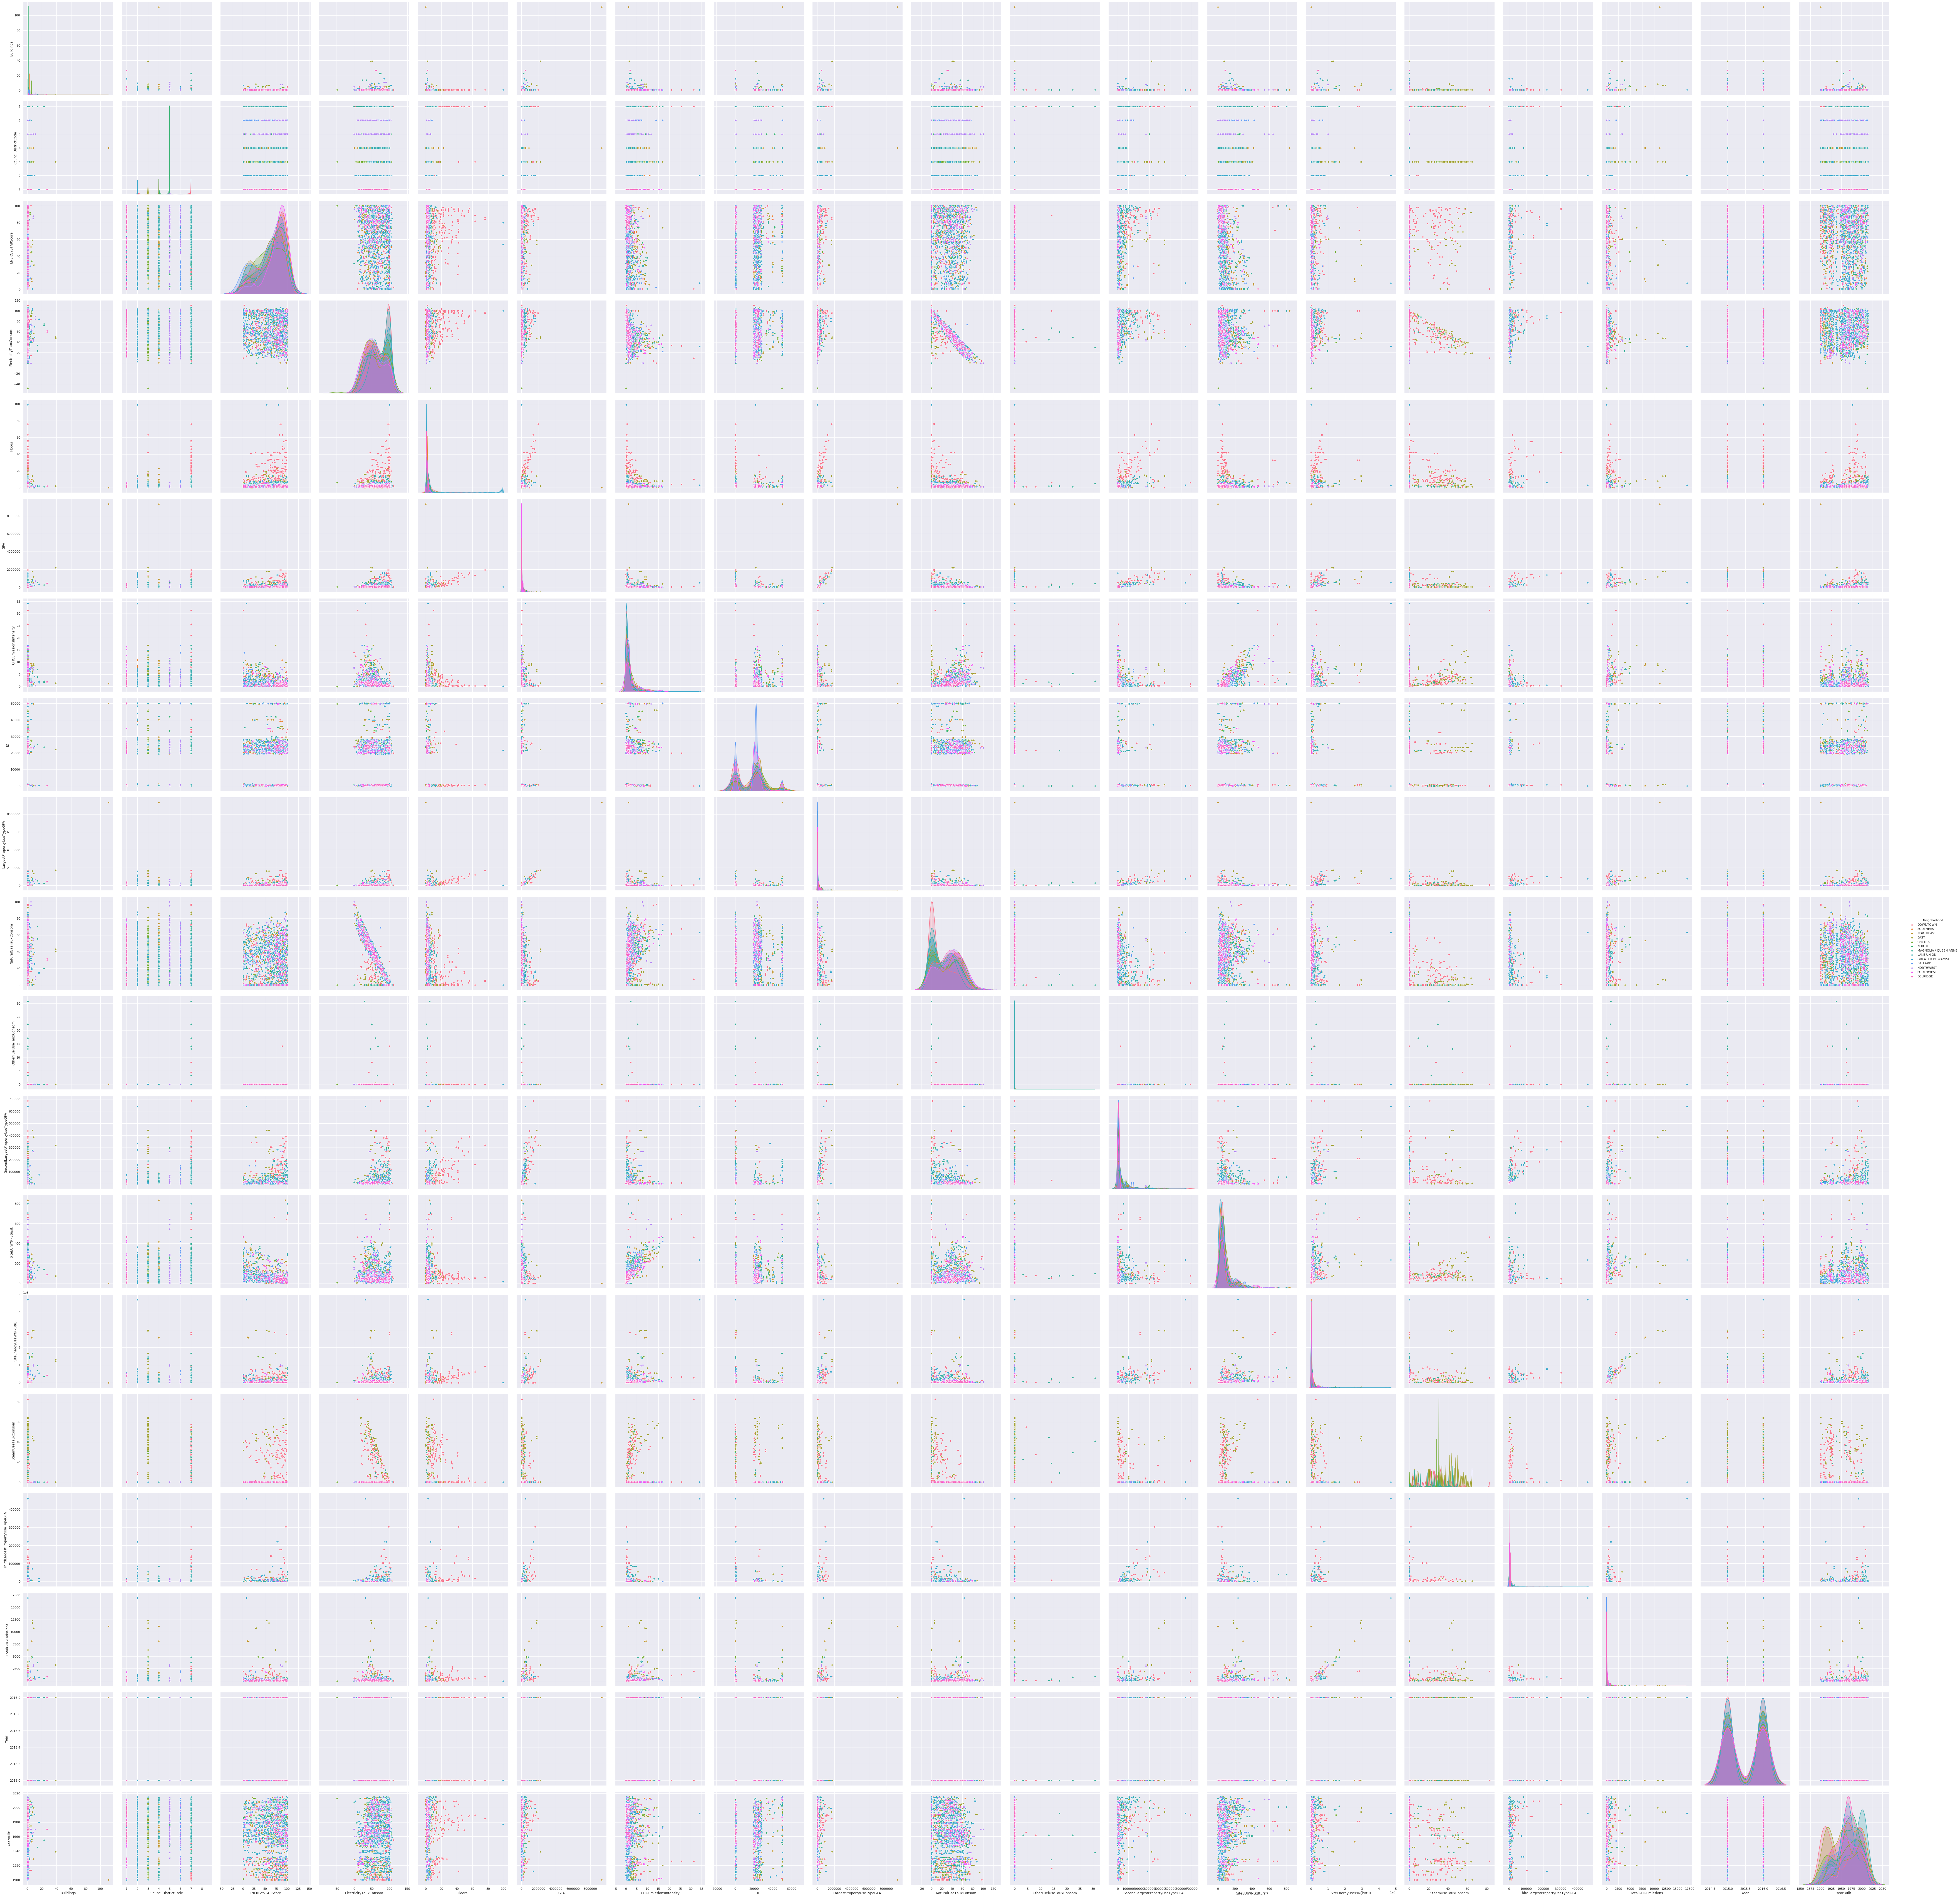

In [0]:
# Pairplot
sns.set()
sns.pairplot(data,height=5,hue='Neighborhood')
plt.show()

La heatmap montre que très peu de corrélations existent, sauf une corrélation négative entre l'électricité et le gaz naturel, ce qui semble logique : plus un bâtiment va utiliser l'électricité, moins il va être relié au gaz naturel et inversement.

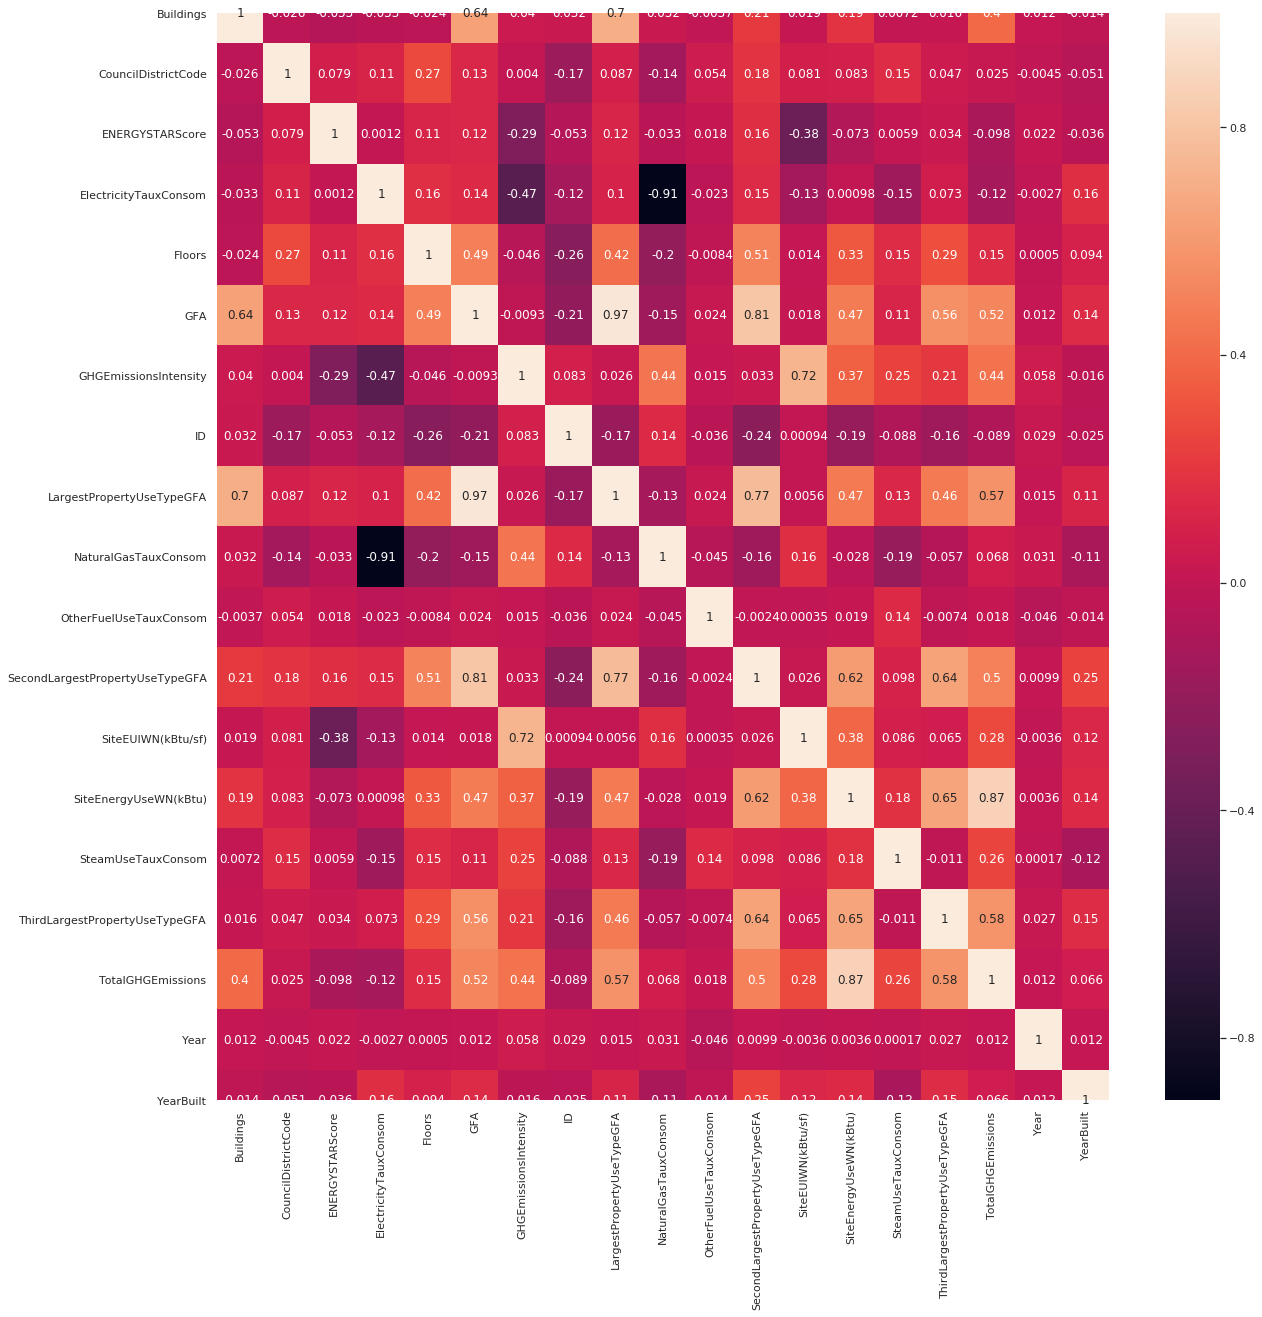

In [0]:
# Heatmap
sns.set()
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(data.corr(),annot=True)
plt.show()

Si nous analysons les variables numériques, nous pouvons voir que :
*   Les bâtiments sont très généralement uniques. Il n'y a que 3,4% de bâtiments constitués de plusieurs immeubles. Il peut potentiellement s'agir de complexes situés à la même adresse et aux immeubles liés entr eux.
*   Les bâtiments sont généralement assez peu élevés (51.3% ont un ou deux étages).
*   Les années de construction sont diverses et variées mais situées dans le XXème siècle en majorité.
*   42% des bâtiments sont dans les quartiers Downtown et Greater Duwamish.

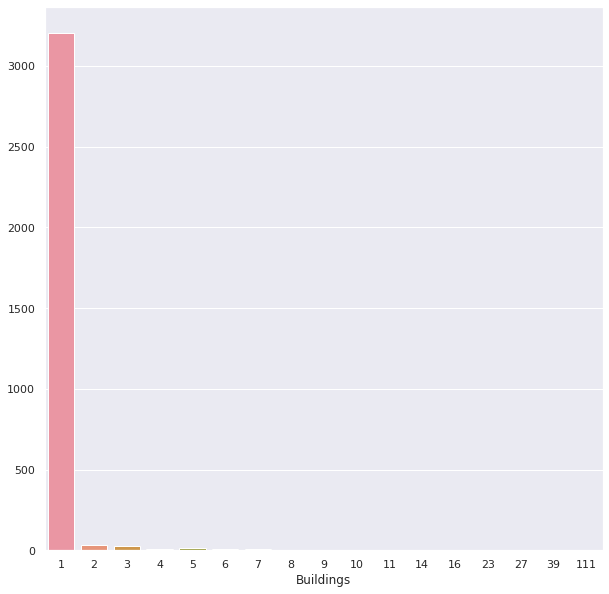

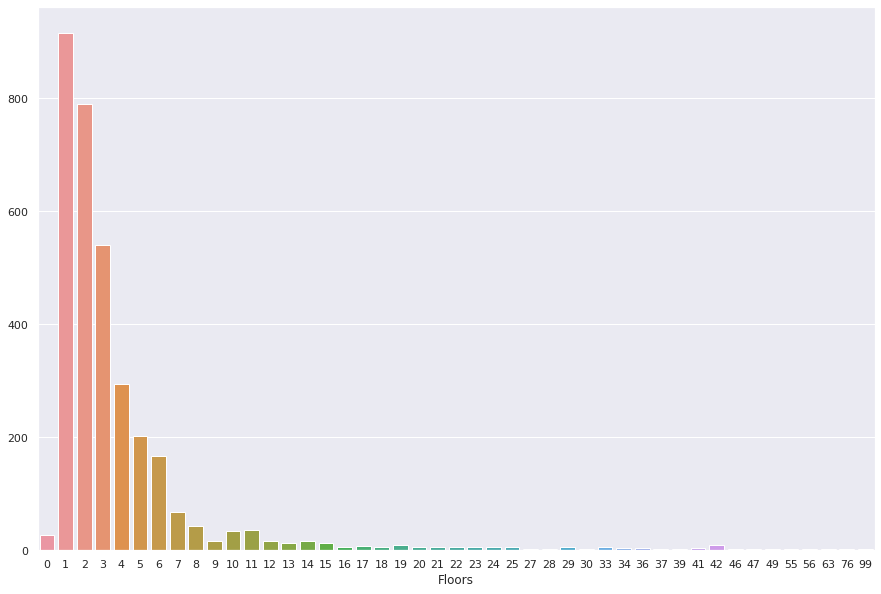

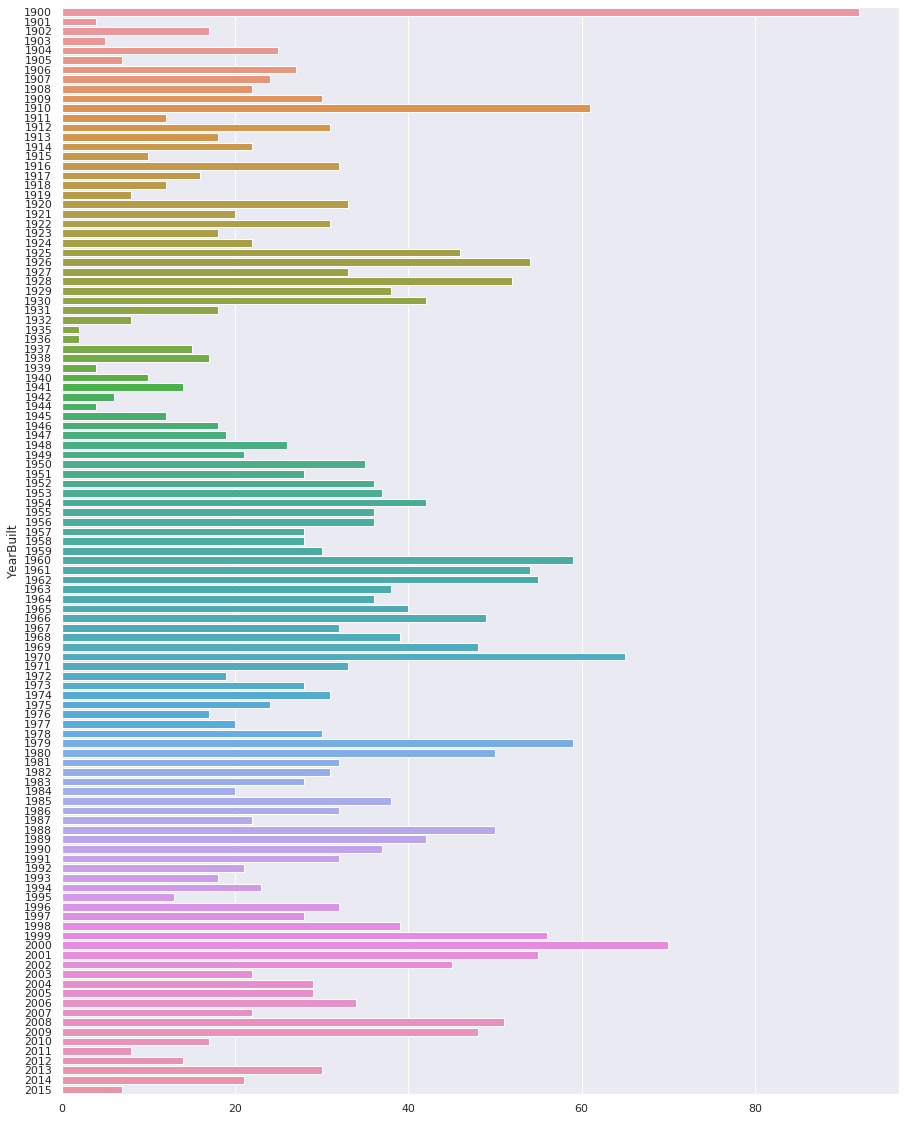

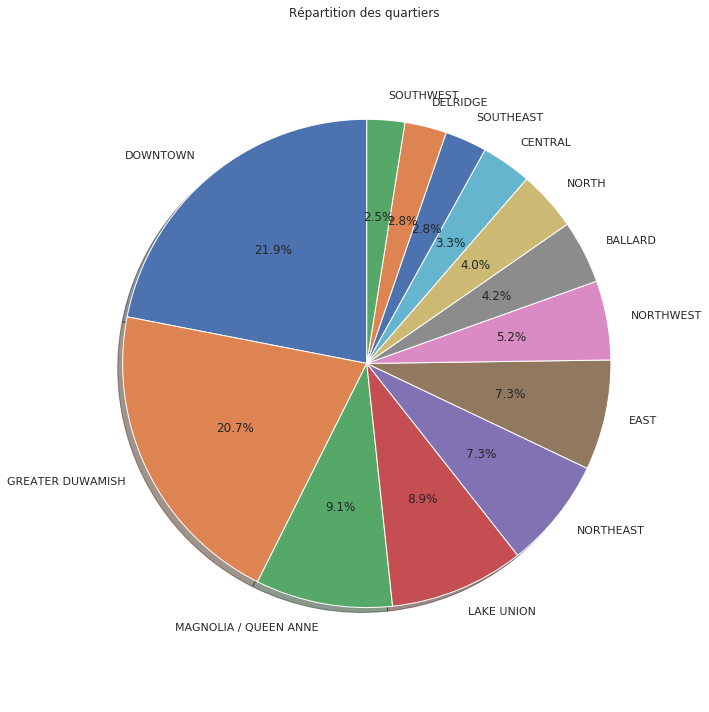

In [0]:
# Camemberts

## NumberofBuildings

building=data.groupby(['Buildings'])
countbuilding=building["ID"].count()
countbuilding=countbuilding.sort_values(ascending = False)
labels = countbuilding.index
sizes = countbuilding.values

sns.set()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.barplot(x=labels, y=sizes)
plt.show()

## NumberofFloors

floor=data.groupby(['Floors'])
countfloor=floor["ID"].count()
countfloor=countfloor.sort_values(ascending = False)
labels = countfloor.index
sizes = countfloor.values

sns.set()
fig, ax = plt.subplots(figsize=(15,10)) 
sns.barplot(x=labels, y=sizes)
plt.show()

## YearBuilt

year=data.groupby(['YearBuilt'])
countyear=year["ID"].count()
countyear=countyear.sort_values(ascending = False)
labels = countyear.index
sizes = countyear.values

sns.set()
fig, ax = plt.subplots(figsize=(15,20)) 
sns.barplot(x=sizes,y=labels,orient="h")
plt.show()

## Neighborhood

neighborhood=data.groupby(['Neighborhood'])
countneighborhood=neighborhood["ID"].count()
countneighborhood=countneighborhood.sort_values(ascending = False)
labels = countneighborhood.index
sizes = countneighborhood.values

sns.set()

fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.title("Répartition des quartiers")
plt.show()

Nous savons que nous avons deux variables séparant la ville de Seattle en quartiers : les variables "CouncilDistrictCode" et "Neighborhood". Si nous étudions la corrélation entre ces deux variables, nous pouvons voir qu'il y a en partie recoupement : hormis deux quartiers, il y a corrélation entre un quartier et au moins un District Code, mais deux District Codes peuvent correspondre à un même quartier. Il s'agit donc de deux découpages de Seattle bien différents, que nous conservons donc. 

Neighborhood          BALLARD   CENTRAL  ...  SOUTHWEST     Total
CouncilDistrictCode                      ...                     
1                    0.000000  0.000000  ...   0.025015  0.071127
2                    0.000000  0.000000  ...   0.000000  0.237794
3                    0.000000  0.033153  ...   0.000000  0.122363
4                    0.000000  0.000000  ...   0.000000  0.100060
5                    0.000000  0.000000  ...   0.000000  0.079566
6                    0.041893  0.000000  ...   0.000000  0.069017
7                    0.000000  0.000000  ...   0.000000  0.320072
Total                0.041893  0.033153  ...   0.025015  1.000000

[8 rows x 14 columns]


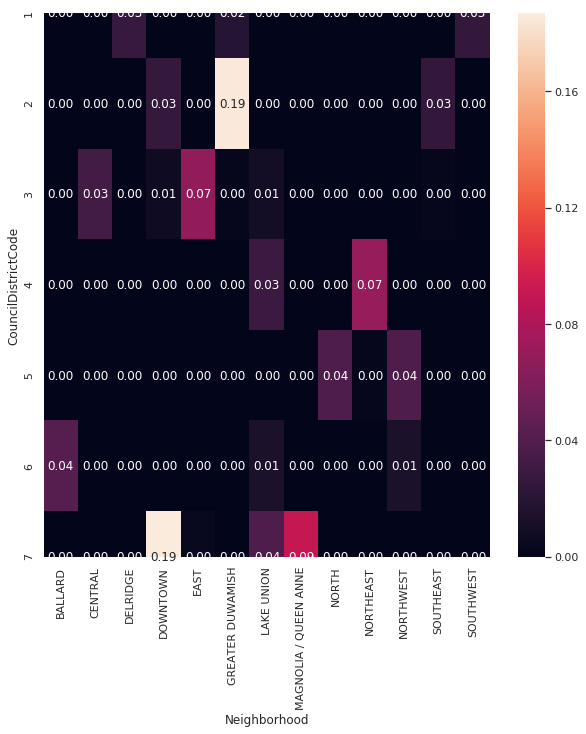

In [35]:
# Corrélation entre CouncilDistrictCode et Neighborhood

X="CouncilDistrictCode"
Y="Neighborhood"
datacorr=data[[X,Y]]
cont = datacorr.pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
c = cont.fillna(0) # On remplace les valeurs nulles par 0
table=c/len(datacorr)

sns.set()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(table.iloc[:-1,:-1],annot=table.iloc[:-1,:-1],fmt='0.2f')
plt.show()

# Traitement des données avant les calculs de modèle

Pour commencer, nous avons vu précédemment que toutes les variables de nos données ne suivaient pas visuellement une distribution gaussienne. Nous prouvons donc cette hypothèse en utilisant le skewness (mesure d'asymétrie d'une variable) : si la valeur de skewness n'est pas entre -2 et 2, la variable ne suit pas une distribution gaussienne. Dans cette situation, nous testons de transformer la variable par un logarithme népérien (LN), ce qui fonctionne hormis pour les variables à valeur de skewness déjà à NaN. Nous ne considérons pas non plus ici toute valeurs numérique non catégorielle, afin de faciliter les traitements futurs.  

In [0]:
print (data.skew(axis = 0, skipna = True))

data["BuildingsLN"]=(np.log(data["Buildings"]+1))
data["FloorsLN"]=(np.log(data["Floors"]+1))
data.drop(["Buildings","Floors" ], axis = 1, inplace = True)

Buildings                          31.836337
CouncilDistrictCode                -0.001451
ENERGYSTARScore                    -0.749241
ElectricityTauxConsom                    NaN
Floors                              6.068476
GFA                                17.083593
GHGEmissionsIntensity               4.677697
ID                                  0.256403
LargestPropertyUseTypeGFA          22.369749
NaturalGasTauxConsom                     NaN
OtherFuelUseTauxConsom                   NaN
SecondLargestPropertyUseTypeGFA     4.103066
SiteEUIWN(kBtu/sf)                  3.516187
SiteEnergyUseWN(kBtu)              10.439212
SteamUseTauxConsom                       NaN
ThirdLargestPropertyUseTypeGFA      7.404385
TotalGHGEmissions                  14.166812
Year                               -0.010855
YearBuilt                          -0.286742
dtype: float64


Nous calculons ensuite l'ANOVA, afin d'étudier si des corrélations sont visibles entre les quartiers et les autres variables. En effet, selon la localisation des bâtiments, des regroupements de consommations peuvent être possibles. Ceci semble effectivement le cas, vu qu'hormis les variables "OtherFuelUse", "SteamUse" et "ThirdLargestPropertyUseTypeGFA", toutes les variables sont corrélées avec les différents quartiers.

Le seul problème à signaler est pour le quartier SouthWest, qui n'est pas considéré dans le code, contrairement aux autres valeurs de quartiers

In [0]:
dataanovaquartiers=data[['ENERGYSTARScore',
       'ElectricityTauxConsom', 'FloorsLN',
       'NaturalGasTauxConsom', 'OtherFuelUseTauxConsom', 
       'SecondLargestPropertyUseTypeGFA',
       'SteamUseTauxConsom', 
       'ThirdLargestPropertyUseTypeGFA', 'YearBuilt', 'BuildingsLN', 'GFA',
       'LargestPropertyUseTypeGFA','Neighborhood']]
dataanovaquartiers.dropna(how="any", inplace=True)
print ("Les différents quartiers : ",data["Neighborhood"].unique())
print ("Calcul des différents ANOVA possibles pour les quartiers :")
grades=dataanovaquartiers.groupby("Neighborhood").groups
for i in (dataanovaquartiers.columns):
  if (i=="Neighborhood"):
    pass
  else:
    #southwest=dataanovaquartiers[i][grades["SOUTHWEST"]]
    downtown=dataanovaquartiers[i][grades["DOWNTOWN"]]
    southeast=dataanovaquartiers[i][grades["SOUTHEAST"]]
    northeast=dataanovaquartiers[i][grades["NORTHEAST"]]
    east=dataanovaquartiers[i][grades["EAST"]]
    central=dataanovaquartiers[i][grades["CENTRAL"]]
    north=dataanovaquartiers[i][grades["NORTH"]]
    magnolia=dataanovaquartiers[i][grades["MAGNOLIA / QUEEN ANNE"]]
    lake=dataanovaquartiers[i][grades["LAKE UNION"]]
    duwamish=dataanovaquartiers[i][grades["GREATER DUWAMISH"]]
    ballard=dataanovaquartiers[i][grades["BALLARD"]]
    northwest=dataanovaquartiers[i][grades["NORTHWEST"]]
    delridge=dataanovaquartiers[i][grades["DELRIDGE"]]
    print ("p-value du quartier et de la variable '",i,"' : ", st.f_oneway(downtown,southeast,northeast,east,central,north,magnolia,lake,duwamish,ballard,northwest,delridge).pvalue )

Les différents quartiers :  ['DOWNTOWN' 'SOUTHEAST' 'NORTHEAST' 'EAST' 'CENTRAL' 'NORTH'
 'MAGNOLIA / QUEEN ANNE' 'LAKE UNION' 'GREATER DUWAMISH' 'BALLARD'
 'NORTHWEST' 'SOUTHWEST' 'DELRIDGE']
Calcul des différents ANOVA possibles pour les quartiers :
p-value du quartier et de la variable ' ENERGYSTARScore ' :  9.49622871123691e-10
p-value du quartier et de la variable ' ElectricityTauxConsom ' :  1.2925149167425474e-06
p-value du quartier et de la variable ' FloorsLN ' :  1.0174463664395865e-29
p-value du quartier et de la variable ' NaturalGasTauxConsom ' :  1.2747330074255685e-10
p-value du quartier et de la variable ' OtherFuelUseTauxConsom ' :  0.9999229767709102
p-value du quartier et de la variable ' SecondLargestPropertyUseTypeGFA ' :  0.1679452750930073
p-value du quartier et de la variable ' SteamUseTauxConsom ' :  0.00039721561818978964
p-value du quartier et de la variable ' ThirdLargestPropertyUseTypeGFA ' :  0.12119079122373747
p-value du quartier et de la variable ' Year

Nous avons un type de données qui semble être intéressant pour nos modèles : les données catégorielles non numériques. Nous les transformons donc en valeurs numériques par la fonction get_dummies(), qui va transfort une variables en plusieurs variables remplies de manière binaire. Pour les quartiers, le compliance status et les outliers, cette transformation suffit à les rendre d'intérêt pour les modèles, mais cela ne suffit pas pour les variables des fonctions des bâtiments.   

In [0]:
data=data.drop(["Outlier","ComplianceStatus"], axis=1)
cols_to_transform = ['PrimaryPropertyType',"Neighborhood",'LargestPropertyUseType','SecondLargestPropertyUseType','ThirdLargestPropertyUseType',"CouncilDistrictCode"]
data = pd.get_dummies(data, columns = cols_to_transform )


Nous avons donc actuellement, pour les fonctions des bâtiments, une colonne par fonction remplie de manière binaire. Pour que cela soit plus intéressant au vu des variables, nous allons changer les valeurs binaires en valeurs allant de 0 à 1 correspondant au pourcentage de surface occupée par la fonction par rapport à la surface totale. Cependant, nous avons environ le tiers des bâtiments qui ont une somme de la surface occupée par les trois fonctions supérieure à 1.



In [0]:
def creation_col(df,listuse) :
  listcol=[]
  listtypes=[]
  listtype=[]
  for x in listuse:
    if (x=="LargestPropertyUseType"):
      search="^"+x
    else:
      search=x
    for col in df.columns:
      if (re.findall(search,col)):
        listcol.append(col)
        types=col.replace(x,'')
        listtypes.append(types)
  for nbr in listtypes:
    if (nbr=="GFA"):
      pass
    elif nbr not in listtype:
            listtype.append(nbr)
  for t in listtype:
    df[t]=0.0
  for c in listcol:
    taux=c+"Taux"
    df[taux]=0.0
  return(listtype,listcol)

def taux_GFA (df,types,col,prop):
  for x in range(len(df)):
    aireglob=(df.at[x,"LargestPropertyUseTypeGFA"])+(df.at[x,"SecondLargestPropertyUseTypeGFA"])+(df.at[x,"ThirdLargestPropertyUseTypeGFA"])
    for p in prop:
      for t in types:
        coltype=p+t  
        if coltype in col:
          if (df.at[x,coltype]==1):
            taux=t+"Taux"
            df.at[x,taux]=(df.at[x,p+"GFA"])/aireglob
            df.at[x,t]=df.at[x,t]+df.at[x,taux]
            if (x==1):
              print ("Exemple sur un bâtiment :")
              print ("Pour ligne ",x)
              print ("Largest : ",p)
              print ("Type : ",t)
              print ("Aire globale : ",aireglob)
              print ("Aire du type : ",df.at[x,p+"GFA"])
              print ("Taux de ",t," : ",df.at[x,t])
  for c in df.columns :
    sup="_"
    if (re.findall("Largest",c)):
      df=df.drop([c], axis=1)
    elif (re.findall("Taux",c)):
      if (re.findall("TauxConsom",c)):
        pass
      else:
        df=df.drop([c], axis=1)
    elif (re.findall("Primary",c)):
      df=df.drop([c], axis=1)
  return df  

def verif (data,listtype):
  print ("\nBâtiments au % supérieur à 1 :")
  len1=0
  for x in range(len(data)):
    typepercent=0.0
    for t in listtype:
      if (data.at[x,t]!=0.0):
        typepercent=typepercent+data.at[x,t]
    if (typepercent>1.0):
      print (x," : ",typepercent)
      len1=len1+1
  print ("\nNombre de bâtiments au % supérieur à 1 : ",len1)
  print ("Nombre de bâtiments totaux : ",len(data))


properties=["LargestPropertyUseType",'SecondLargestPropertyUseType','ThirdLargestPropertyUseType']
listtype,listcol=creation_col(data,properties)
data=taux_GFA(data,listtype,listcol,properties)
verif(data,listtype)


Exemple sur un bâtiment :
Pour ligne  1
Largest :  LargestPropertyUseType
Type :  _Hotel
Aire globale :  103566.0
Aire du type :  83880.0
Taux de  _Hotel  :  0.8099183129598517
Exemple sur un bâtiment :
Pour ligne  1
Largest :  SecondLargestPropertyUseType
Type :  _Parking
Aire globale :  103566.0
Aire du type :  15064.0
Taux de  _Parking  :  0.1454531409922175
Exemple sur un bâtiment :
Pour ligne  1
Largest :  ThirdLargestPropertyUseType
Type :  _Restaurant
Aire globale :  103566.0
Aire du type :  4622.0
Taux de  _Restaurant  :  0.04462854604793079

Bâtiments au % supérieur à 1 :
25  :  1.0000000000000002
1675  :  1.0000000000000002

Nombre de bâtiments au % supérieur à 1 :  2
Nombre de bâtiments totaux :  3318


In [0]:
for i in data.columns:
  print (i)

BuildingType
ENERGYSTARScore
ElectricityTauxConsom
GFA
GHGEmissionsIntensity
ID
Location
NaturalGasTauxConsom
OtherFuelUseTauxConsom
PropertyName
SiteEUIWN(kBtu/sf)
SiteEnergyUseWN(kBtu)
SteamUseTauxConsom
TotalGHGEmissions
Year
YearBuilt
BuildingsLN
FloorsLN
Neighborhood_BALLARD
Neighborhood_CENTRAL
Neighborhood_DELRIDGE
Neighborhood_DOWNTOWN
Neighborhood_EAST
Neighborhood_GREATER DUWAMISH
Neighborhood_LAKE UNION
Neighborhood_MAGNOLIA / QUEEN ANNE
Neighborhood_NORTH
Neighborhood_NORTHEAST
Neighborhood_NORTHWEST
Neighborhood_SOUTHEAST
Neighborhood_SOUTHWEST
CouncilDistrictCode_1
CouncilDistrictCode_2
CouncilDistrictCode_3
CouncilDistrictCode_4
CouncilDistrictCode_5
CouncilDistrictCode_6
CouncilDistrictCode_7
_Adult Education
_Automobile Dealership
_Bank Branch
_College/University
_Convention Center
_Courthouse
_Data Center
_Distribution Center
_Financial Office
_Fire Station
_Fitness Center/Health Club/Gym
_Food Service
_Hospital (General Medical & Surgical)
_Hotel
_K-12 School
_Labora

In [0]:
# Sauvegarde du fichier pour le modèle pour l'analyse
data.to_csv('datatrait.csv', sep = '\t',index=False)
print ("Fichier créé")
uploaded = drive.CreateFile({'title': 'datatrait.csv'})
uploaded.SetContentFile('datatrait.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))


Fichier créé
Uploaded file with ID 1hPUotB-TTmhH71Wb1h8NZLFhzVkXITct
